In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(os.path.normpath(SRC_DIR))

import platform
import operator
import itertools
import datetime as dt

import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
from IPython.display import display

from pipeline import JHU, CTP, NYT, DPC, ECDC
from utils import write_csv, ISO_3166_2

seaborn.set(palette='pastel')
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

print("python", platform.python_version())
print("pandas", pd.__version__)

python 3.8.2
pandas 1.0.3


## data sources

In [3]:
kwargs = dict(verbose=True)
SOURCES = {
#     'jhu': JHU(**kwargs),
#     'ctp': CTP(**kwargs),
    'nyt': NYT(**kwargs),
    'dpc': DPC(**kwargs),
    'ecdc': ECDC(**kwargs),
}
CATALOG = {k: v.clean for k, v in SOURCES.items()}

for name, df in CATALOG.items():
    display(f'preview: {name}', df.tail(3))

Reading 'us-counties.csv'...
No cached file 'us-counties.csv', fetching from server...
Fetched file 'us-counties.csv'. Caching for later.
Reading 'dpc-covid19-ita-regioni.csv'...
No cached file 'dpc-covid19-ita-regioni.csv', fetching from server...
Fetched file 'dpc-covid19-ita-regioni.csv'. Caching for later.
Reading 'csv'...
No cached file 'csv', fetching from server...
Fetched file 'csv'. Caching for later.


'preview: nyt'

,date,county,state,fips,cases,deaths
26196,2020-04-01,Sweetwater,Wyoming,56037,3,0
26197,2020-04-01,Teton,Wyoming,56039,26,0
26198,2020-04-01,Washakie,Wyoming,56043,1,0


'preview: dpc'

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,date
816,2020-04-02 17:00:00,ITA,18,Calabria,38.905976,16.594402,163,19,182,445,627,17,22,23,41,691,10679,NaN,NaN,2020-04-02
817,2020-04-02 17:00:00,ITA,19,Sicilia,38.115697,13.362357,503,73,576,1030,1606,62,73,92,93,1791,17833,NaN,NaN,2020-04-02
818,2020-04-02 17:00:00,ITA,20,Sardegna,39.215312,9.110616,117,24,141,577,718,43,49,36,40,794,5970,NaN,NaN,2020-04-02


'preview: ecdc'

,date_rep,day,month,year,cases,deaths,countries_and_territories,geo_id,countryterritory_code,pop_data2018,date
8301,2020-04-02,2,4,2020,235,0,Vietnam,VN,VNM,95540395.0,2020-04-01
8302,2020-04-02,2,4,2020,36,0,Zambia,ZM,ZMB,17351822.0,2020-04-01
8303,2020-04-02,2,4,2020,8,1,Zimbabwe,ZW,ZWE,14439018.0,2020-04-01


## ontology

In [4]:
METRICS = ['cases', 'deaths']
LIMITS = dict(zip(METRICS, [100, 10]))
LEVELS = ['country', 'state', 'county']


def rollup(df, level):
    df = df.copy()
    if level == 'county':
        return df

    agg_level = ['date', 'day', 'country']

    if level == 'state':
        gdf = df.groupby([*agg_level, 'state'])
    else:
        gdf = df.groupby(agg_level)

    return (
        gdf
        .agg({**dict(zip(METRICS, [sum, sum, sum])),
              'source': set})
        .assign(source=lambda df: df['source'].map(lambda x: ','.join(x)))
        .reset_index()
    )


def levels_in_df(df):
    return [l for l in LEVELS if l in df.columns]


### combined

In [5]:
COLS = [
    'date',
    *LEVELS,
    *METRICS,
    'updated',
    'source',
]

nyt_dates = CATALOG['nyt']['date'].drop_duplicates().values
dpc_dates = CATALOG['dpc']['date'].drop_duplicates().values

df = pd.concat([
    
    CATALOG['ecdc'].copy()
    .rename(columns={
        'countries_and_territories': 'country',
    })
    # all data except US data in NYT
    .loc[lambda df: (df['country'] != 'US')]# | ~df['date'].isin(nyt_dates)]
    # all data except Italy data in DPC
    .loc[lambda df: (df['country'] != 'Italy')]# | ~df['date'].isin(dpc_dates)]
    .assign(
        state=np.nan,
        county=np.nan,
        source='ecdc',
        updated=lambda df: df['date'],
    )
    [COLS],

#     CATALOG['jhu'].copy()
#     .rename(columns={
#         'country_region': 'country',
#         'province_state': 'state',
#         'admin2': 'county',
#         'confirmed': 'cases',
#     })
#     # all data except US data in NYT
#     .loc[lambda df: (df['country'] != 'US') | ~df['date'].isin(nyt_dates)]
#     # all data except Italy data in DPC
#     .loc[lambda df: (df['country'] != 'Italy') | ~df['date'].isin(dpc_dates)]
#     .assign(
#         updated=lambda df: df['last_update'].fillna(df['date']),
#         source='jhu'
#     )
#     [COLS],

    # US metrics from NYT
    CATALOG['nyt'].copy()
    .assign(
        country='US',
        source='nyt',
        updated=lambda df: df['date'],
    )
    [COLS],
    
    # Italy metrics from DPC
    CATALOG['dpc'].copy()
    .rename(columns={
        'denominazione_regione': 'state',
        'totale_casi': 'cases',
        'deceduti': 'deaths',
        'data': 'updated',
    })
    .assign(
        country='Italy',
        county=lambda df: df['state'],
        source='dpc',
    )
    [COLS]
])


df = (
    df
    .assign(
        day=lambda df: df['date'].dt.strftime('%Y-%m-%d'),
        cases=lambda df: df['cases'].fillna(0),
        # when state doesn't exist and a metric refers to the country,
        # `state` is sometimes NaN and sometimes <countryname>. therefore
        # normalize on <countryname> to make aggregations easy
        state=lambda df: df['state'].fillna(df['country']),
        county=lambda df: df['county'].fillna(df['state']),
    )
    .loc[lambda df: df['cases'] > 0]  # only non-zero cases interesting
    .sort_values(['date', *LEVELS])
    .reset_index(drop=True)
)

write_csv(df.drop(['day'], axis=1).replace(SOURCES), 'covid19-combined.csv')
CATALOG['df.combined'] = df
display('sources', df['source'].value_counts())
display('preview', df.loc[df['country'] == 'UK'].tail())

'sources'

nyt     26199
ecdc     5156
dpc       746
Name: source, dtype: int64

'preview'

,date,country,state,county,cases,deaths,updated,source,day
20712,2020-03-28,UK,UK,UK,17089,1019,2020-03-28,ecdc,2020-03-28
22821,2020-03-29,UK,UK,UK,19522,1228,2020-03-29,ecdc,2020-03-29
25018,2020-03-30,UK,UK,UK,22141,1408,2020-03-30,ecdc,2020-03-30
27317,2020-03-31,UK,UK,UK,25150,1789,2020-03-31,ecdc,2020-03-31
29700,2020-04-01,UK,UK,UK,29474,2532,2020-04-01,ecdc,2020-04-01


### derived

In [6]:
def with_cfr(df):
    df['cfr'] = 100 * (df['deaths'].fillna(0) / df['cases'])
    return df


def with_diffs(df):
    agg_level = levels_in_df(df)
    df[[f"{m}_new" for m in METRICS]] = (
        df
        .sort_values('date')
        .groupby(agg_level)[METRICS]
        .diff()
    )
    return df


def with_pct_change(df):
    agg_level = levels_in_df(df)
    df[[f"{m}_pct_change" for m in METRICS]] = 100 * (
        df
        .sort_values('date')
        .groupby(agg_level)[METRICS]
        .pct_change()
    )
    return df

In [7]:
for i, level in enumerate(LEVELS):
    df = (
        rollup(CATALOG['df.combined'], level)
        .pipe(with_cfr)
        .pipe(with_diffs)
        .pipe(with_pct_change)
    )
    CATALOG[f'df.derived.{level}'] = df

df = CATALOG['df.derived.country']
df = df.loc[df['country'] == 'UK']
display('preview', df.tail())

'preview'

,date,day,country,cases,deaths,source,cfr,cases_new,deaths_new,cases_pct_change,deaths_pct_change
4336,2020-03-28,2020-03-28,UK,17089,1019,ecdc,5.962900,2546.0,260.0,17.506704,34.255599
4531,2020-03-29,2020-03-29,UK,19522,1228,ecdc,6.290339,2433.0,209.0,14.237229,20.510304
4726,2020-03-30,2020-03-30,UK,22141,1408,ecdc,6.359243,2619.0,180.0,13.415634,14.657980
4920,2020-03-31,2020-03-31,UK,25150,1789,ecdc,7.113320,3009.0,381.0,13.590172,27.059659
5117,2020-04-01,2020-04-01,UK,29474,2532,ecdc,8.590622,4324.0,743.0,17.192843,41.531582


### offset

In [8]:
def with_offset(df, metric, limit=100):
    col = f"{metric}_offset"
    agg_level = levels_in_df(df)
    df[col] = (
        df
        .copy()
        .loc[df[metric] >= limit]
        .sort_values([*agg_level, 'date', 'day'])
        .groupby(agg_level)[metric]
        .cumcount()
    )
    return df


def reindex_offset(df, offset):
    agg_level = levels_in_df(df)
    df = (
        df
        .copy()
        .dropna(subset=[offset])
        .set_index([offset, 'offset_metric', *agg_level])
        .reset_index()
    )
    return df


In [9]:
for i, level in enumerate(LEVELS):
    df = CATALOG[f'df.derived.{level}'].copy()
    id_vals = df.columns.values
    df = (
        df
        .pipe(with_offset, 'cases', LIMITS['cases'])
        .pipe(with_offset, 'deaths', LIMITS['deaths'])
        .melt(
            id_vals,
            [f'{m}_offset' for m in METRICS],
            'offset_metric',
            'offset'
        )
        .replace(r"_offset$", '', regex=True)
        .pipe(reindex_offset, 'offset')
    )
    CATALOG[f'df.offset.{level}'] = df

df = CATALOG['df.offset.country']
df = df.loc[(df['country'] == 'Italy')
            & (df['offset_metric'] == 'cases')]
display('preview', df.tail())

'preview'

,offset,offset_metric,country,date,day,cases,deaths,source,cfr,cases_new,deaths_new,cases_pct_change,deaths_pct_change
1432,34.0,cases,Italy,2020-03-29,2020-03-29,97689,10779,dpc,11.033996,5217.0,756.0,5.641708,7.542652
1538,35.0,cases,Italy,2020-03-30,2020-03-30,101739,11591,dpc,11.392878,4050.0,812.0,4.145810,7.533166
1647,36.0,cases,Italy,2020-03-31,2020-03-31,105792,12428,dpc,11.747580,4053.0,837.0,3.983723,7.221120
1759,37.0,cases,Italy,2020-04-01,2020-04-01,110574,13155,dpc,11.897010,4782.0,727.0,4.520191,5.849694
1819,38.0,cases,Italy,2020-04-02,2020-04-02,115242,13915,dpc,12.074591,4668.0,760.0,4.221607,5.777271


## visualization

### overview

In [10]:
# filter to latest date and significant impact
df = CATALOG['df.derived.country'].copy()
levels = levels_in_df(df)
df = (
    df
    .sort_values([*levels, 'date'])
    .groupby(levels)
    .last()
    .reset_index()
)

display(
    "totals",
    df
    [METRICS]
    .sum()
    .rename('total')
    .map(lambda x: f"{x:,.0f}")
    .to_frame()
)

def prettify(df):
    for m in [*METRICS, *[f'{m}_new' for m in METRICS]]:
        df[m] = df[m].map(lambda x: f"{x:,.0f}")
    for m in ['cfr', *[f'{m}_pct_change' for m in METRICS]]:
        df[m] = df[m].map(lambda x: f"{x:,.1f}")
    if 'state' in df.columns:
        df.loc[df['country'] == df['state'], 'state'] = ''
    if 'county' in df.columns:
        df.loc[df['country'] == df['county'], 'county'] = ''
    return df.drop(['day'], axis=1)

metric = 'deaths'
limit = LIMITS[metric] * 5

df = df.query(f'{metric} >= {LIMITS["deaths"]}')
idx = ['date', 'source', *levels, *METRICS]

display(
    f"regions with most {metric}",
    prettify(df.sort_values(metric, ascending=False))
    [[*idx, f'{metric}_new', 'cfr']]
    .reset_index(drop=True)
    .head(10)
)
display(
    f"regions fastest growing, regions with {limit} or more new {metric}/day",
    prettify(df.query(f'{metric}_new > {limit}')
               .sort_values(f'{metric}_pct_change', ascending=False))
    [[*idx, f'{metric}_new', f'{metric}_pct_change']]
    .reset_index(drop=True)
    .head(10)
)

'totals'

,total
cases,"931,058"
deaths,"47,062"


'regions with most deaths'

,date,source,country,cases,deaths,deaths_new,cfr
0,2020-04-02,dpc,Italy,"115,242","13,915",760,12.1
1,2020-04-01,ecdc,Spain,"102,136","9,053",864,8.9
2,2020-04-01,nyt,US,"214,682","4,551",921,2.1
3,2020-04-01,ecdc,France,"56,989","4,032",509,7.1
4,2020-04-01,ecdc,China,"82,395","3,316",6,4.0
5,2020-04-01,ecdc,Iran,"47,593","3,036",138,6.4
6,2020-04-01,ecdc,UK,"29,474","2,532",743,8.6
7,2020-04-01,ecdc,Netherlands,"13,614","1,173",134,8.6
8,2020-04-01,ecdc,Germany,"73,522",872,140,1.2
9,2020-04-01,ecdc,Belgium,"13,964",828,123,5.9


'regions fastest growing, regions with 50 or more new deaths/day'

,date,source,country,cases,deaths,deaths_new,deaths_pct_change
0,2020-04-01,ecdc,Ecuador,"2,758",146,67,84.8
1,2020-04-01,ecdc,UK,"29,474","2,532",743,41.5
2,2020-04-01,ecdc,Sweden,"4,947",239,59,32.8
3,2020-04-01,ecdc,Turkey,"15,679",277,63,29.4
4,2020-04-01,nyt,US,"214,682","4,551",921,25.4
5,2020-04-01,ecdc,Germany,"73,522",872,140,19.1
6,2020-04-01,ecdc,Belgium,"13,964",828,123,17.4
7,2020-04-01,ecdc,France,"56,989","4,032",509,14.4
8,2020-04-01,ecdc,Netherlands,"13,614","1,173",134,12.9
9,2020-04-01,ecdc,Spain,"102,136","9,053",864,10.6


## timeseries

In [11]:
EU5 = ['Italy', 'United Kingdom', 'Germany', 'Spain', 'France']
NORDICS = ['Sweden', 'Denmark', 'Norway', 'Finland']


def infotext(size):
    attr = {'long': 'name', 'short': 'shortname'}
    sources = map(lambda o: getattr(o, attr[size]), SOURCES.values())
    return f"updated: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}\n" \
           f"sources: {', '.join(sources)}"


def set_yaxis(ax):
    def formatter(number, pos=None):
        """Convert a number into a human readable format."""
        magnitude = 0
        while abs(number) >= 1000:
            magnitude += 1
            number /= 1000.0
        decimals = 1 if number < 1 else 0
        return f"{number:,.{decimals}f}{['', 'k', 'M', 'B'][magnitude]}"

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
    
    # human readable y scale ticks
    ymin, ymax = ax.get_ylim()
    ticks = map(lambda x: (x, 2 * x, 5 * x), ax.get_yticks())
    ticks = itertools.chain(*ticks)
    ticks = list(filter(lambda y: (y > ymin) & (y < ymax), ticks))[1:]
    if len(ticks) > 10:
        ticks = ticks[2:]
    ax.set_yticks(ticks)

    
def set_data_labels(ax, values, series):
    # skip trailing NaNs
    values = values.loc[:values.last_valid_index()].values
    for i, v in enumerate(values):
        # plot when i has same parity as number of elements
        # e.g. for 20 values, want to plot odd numbered values
        # to ensure i=19 (last element) is annotated
        if ((len(values) % 2) == ((i + 1) % 2)) & (v > 0):
            frmt = f'{v:,.1f}' if series in ['cfr'] else f'{v:,.0f}'
            bbox = dict(pad=0.5, facecolor='white', alpha=0.5)
            ax.text(i, v, frmt, ha='left', va='top', fontsize=7, bbox=bbox)


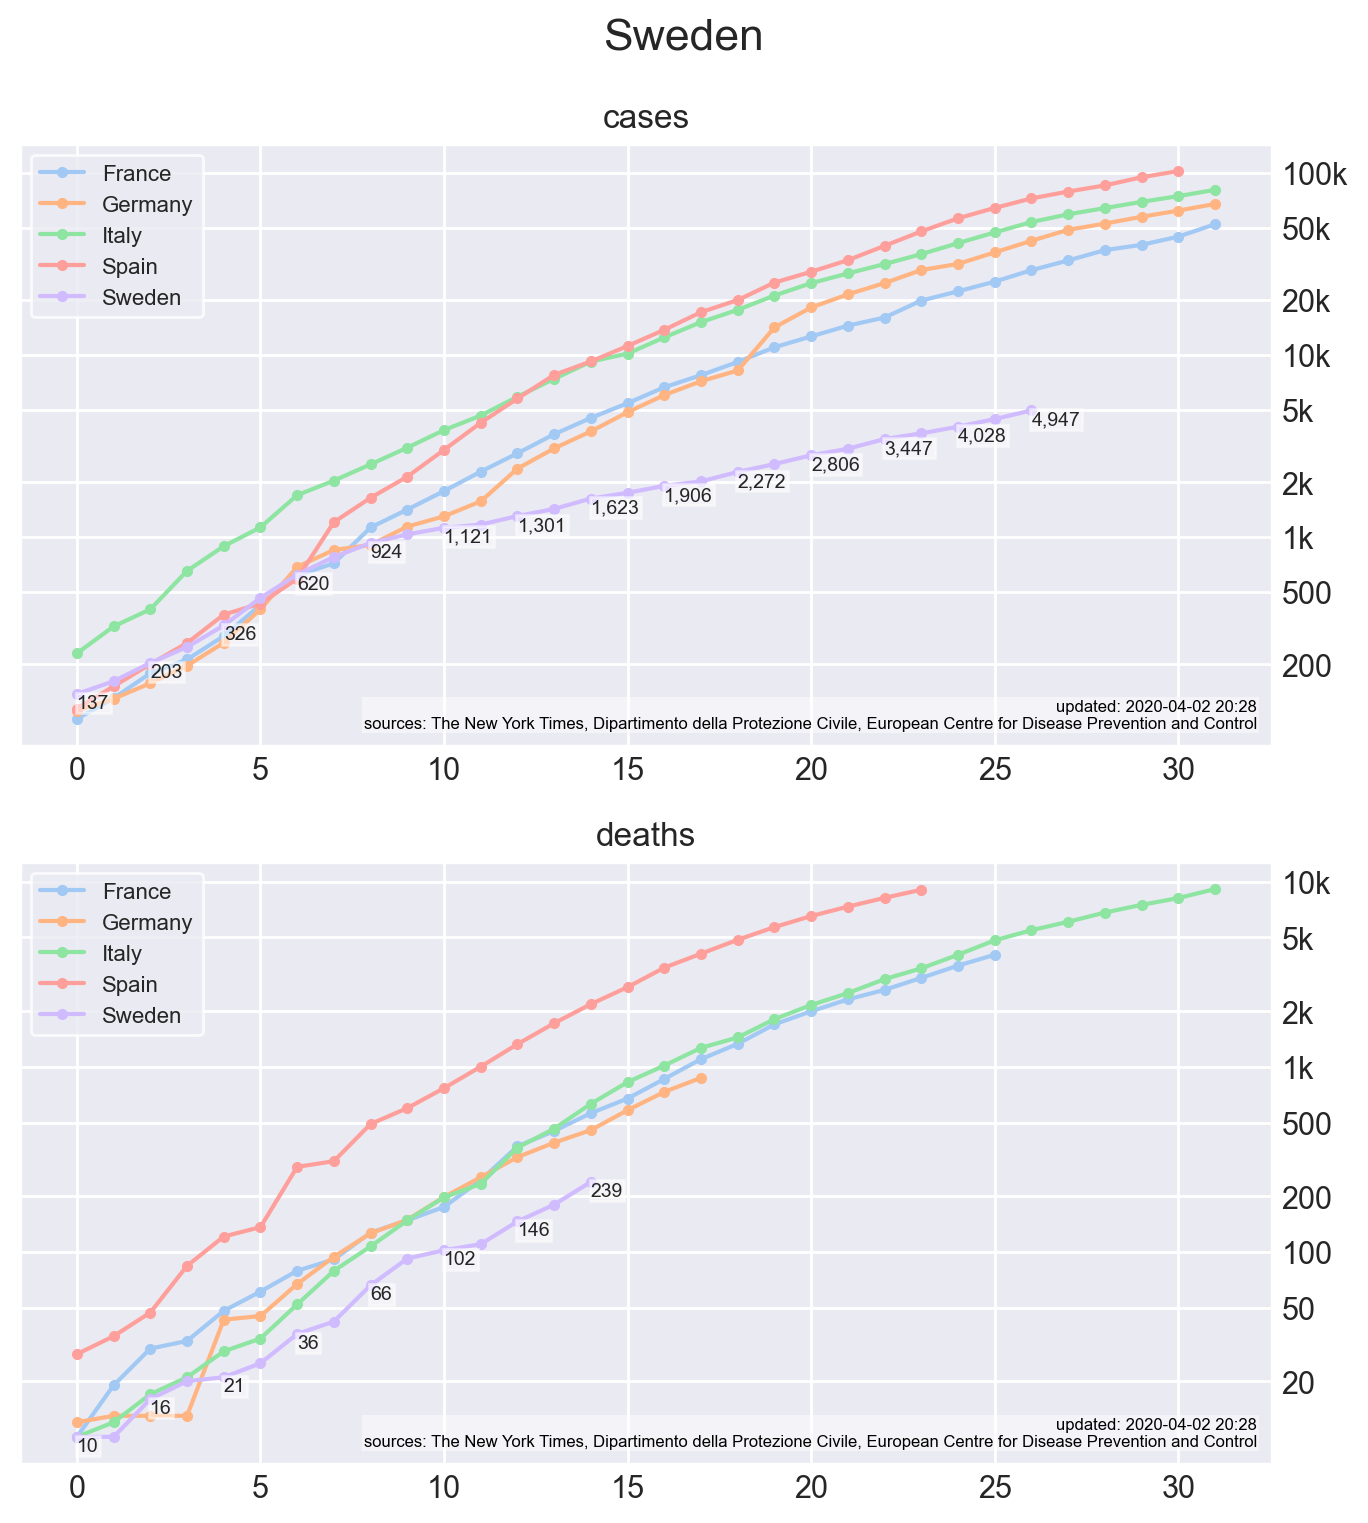

In [14]:
def get_timeseries(series, metric, offset_metric):
    dfs = {}
    for level, config in series.items():
        df = config['df'].copy()

        # county names may clash with state names so deconflict
        if level == 'county':
            df['_state'] = df['state'].replace(ISO_3166_2)
            df['county'] = df[['county', '_state']].agg(', '.join, axis=1)
            df = df.drop(['_state'], axis=1)

        filter_level = config.get('series_level', level)
        df = (
            df
            .loc[lambda df: df['offset_metric'] == offset_metric]
            .loc[lambda df: df[filter_level].isin(config['series'])]
        )
        
        if 'state' not in df.columns:
            df['state'] = df['country']
        if 'county' not in df.columns:
            df['county'] = df['state']
        dfs[level] = df

    df = pd.concat(dfs)
    # coalesce(county, state, country)
    df['region'] = df['county'].fillna(df['state']).fillna(df['country'])
    df = df.pivot(index='offset', columns='region', values=metric)
    return df


def plot(series, plots, days, highlight='Italy', dpi=100):

    from_date = (dt.datetime.now() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    
    rows = len(plots)
    fig, axs = plt.subplots(rows, 1, figsize=(7, rows * 4), dpi=dpi, facecolor='white')
    
    for i, t in enumerate(plots.items()):
        metric, offset_metric = t
        ax = axs[i] if rows > 1 else axs

        ts = get_timeseries(series, metric, offset_metric)[:days]
        ts.plot(title=metric, marker='.', ax=ax)
        
        # y-axis
        ax.set_yscale('log', basey=10)
        set_yaxis(ax)
        ax.yaxis.tick_right()
        ax.tick_params(axis='both', which='both',length=0)

        # x-axis
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(range(0, days, 5))
        
        # data labels
        set_data_labels(ax, ts[highlight], series)

        # info text box
        props = dict(color='black', fontsize=6, multialignment='right')
        box = AnchoredText(infotext('long'), loc=4, frameon=True, pad=0.1,
                           borderpad=0.8, prop=props)
        plt.setp(box.patch, facecolor='white', alpha=0.5, linewidth=0)
        ax.add_artist(box)
        
        # legend
        plt.sca(ax)
        leg = plt.legend(loc=2, prop={'size':8})
        leg.get_frame().set_edgecolor('white')
        leg.get_frame().set_linewidth(1.0)

    if rows > 1:
        fig.suptitle(highlight, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


plot(
    series={
        'country': {
            'df': CATALOG['df.offset.country'],
            'series': EU5 + ['Sweden'],
        },
#         'state': {
#             'df': CATALOG['df.offset.state'],
#             'series': ['New York', 'California', 'Lombardia'],
# #             'series': ['Italy'],
# #             'series_level': 'country',
#         },
#         'county': {
#             'df': CATALOG['df.offset.county'],
#             'series': [
#                 'New York City, NY', 'Westchester, NY', 'Nassau, NY',
#                 'Los Angeles, CA', 'Santa Clara, CA', 'San Francisco, CA',
#             ],
# #             'series': ['California'],
# #             'series_level': 'state',
#         }
    },
    plots={  # k = metric to plot; v = offset_metric index to use
        'cases': 'cases',
        'deaths': 'deaths',
#         'deaths_new': 'deaths',
#         'cases_new': 'cases',
    },
    days=31,
    **dict(highlight='Sweden', dpi=200),
)

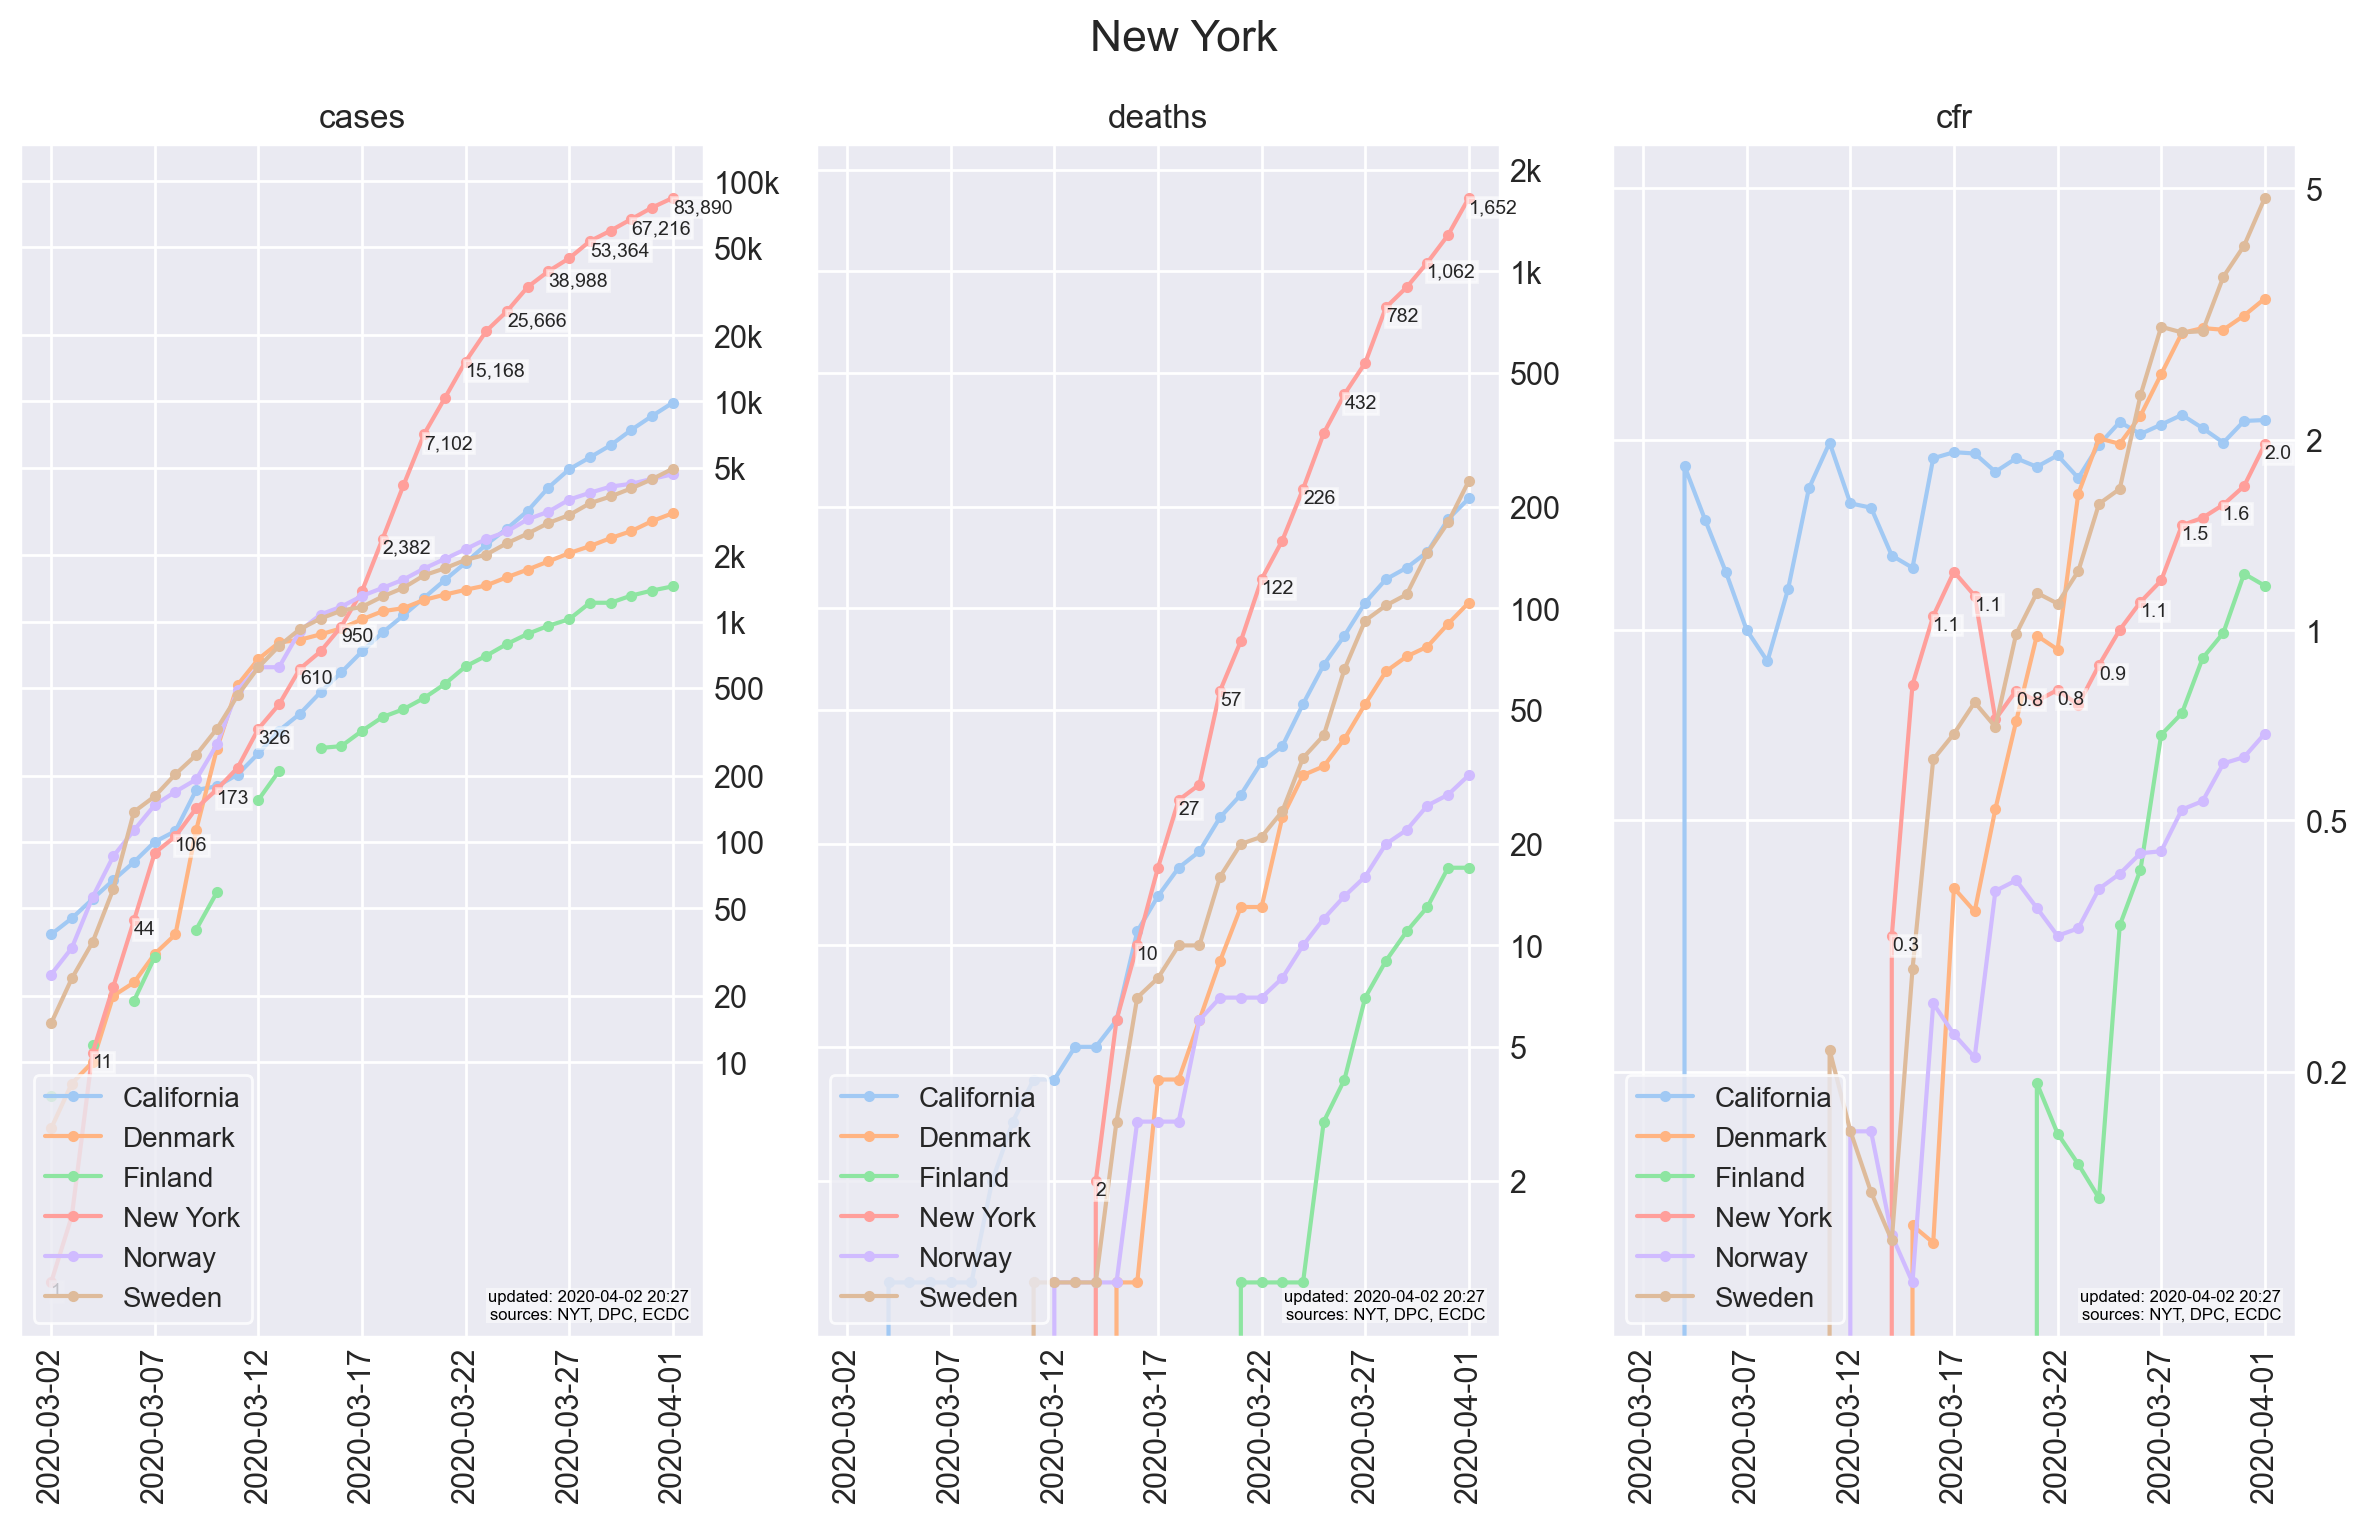

In [13]:
def get_timeseries(df, index, series, country=None, state=None, rollup_states=True):
    df = df.copy()

    if isinstance(country, str):
        country = [country]
    if isinstance(state, str):
        state = [state]

    df_country = df.loc[df['country'].isin(country)] if country else pd.DataFrame()

    if country and rollup_states:
        df_country = (
            rollup(df_country, 'country')
            .assign(state=lambda x: x['country'])
            .pipe(with_cfr)
            .pipe(with_diffs)
            .pipe(with_pct_change)
        )

    df_state = df.loc[df['state'].isin(state)] if state else pd.DataFrame()
    df = pd.concat([df_country, df_state], sort=True)

    df['region'] = df['state'].fillna(df['country'])#.str.lower()
    df = df.pivot(index=index, columns='region', values=series)
    return df


def plot(countries, states, plots, days, highlight='Italy', dpi=100):

    from_date = (dt.datetime.now() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    
    cols = len(plots)
    fig, axs = plt.subplots(1, cols, figsize=(cols * 4, 8), dpi=dpi, facecolor='white')
    
    for i, t in enumerate(plots.items()):
        series, df = t
        ax = axs[i] if cols > 1 else axs

        ts = get_timeseries(
            df,
            index='day',
            series=series,
            country=countries,
            state=states,
        )[from_date:]

        ax = ts.plot(title=series, legend=True, marker='.', ax=ax)
        
        # y-axis
        ax.set_yscale('log', basey=10)
        set_yaxis(ax)
        ax.yaxis.tick_right()
        ax.tick_params(axis='both', which='both',length=0)

        # x-axis
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(range(0, days, 5))
        ax.set_xticklabels(ts.index.values[::5])
        plt.setp(ax.get_xticklabels(), rotation=90)
        
        # data labels
        set_data_labels(ax, ts[highlight], series)

        # info text box
        props = dict(color='black', fontsize=6, multialignment='right')
        box = AnchoredText(infotext('short'), loc=4, frameon=True, pad=0.1,
                           borderpad=0.8, prop=props)
        plt.setp(box.patch, facecolor='white', alpha=0.5, linewidth=0)
        ax.add_artist(box)
        
        # legend
        plt.sca(ax)
        leg = plt.legend(loc=3, prop={'size':10})
        leg.get_frame().set_edgecolor('white')
        leg.get_frame().set_linewidth(1.0)

    if cols > 1:
        fig.suptitle(highlight, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


# works best when picking 4-8 countries/states
df = CATALOG['df.derived.state']

plot(
    countries=NORDICS,
    states=['California', 'New York'],
    plots={
        'cases': df,
        'deaths': df,
        'cfr': df,
    },
    days=31,
    **dict(highlight='New York', dpi=200),
)